General imports

In [1]:
!pip install einops
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 386 (delta 3), reused 2 (delta 2), pack-reused 381 (from 2)
Receiving objects: 100% (386/386), 3.85 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

Dataset

In [4]:
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T

dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=T.ToTensor())

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [ ]:
print(len(dataset))

1449


Helper function

In [5]:
def show_cam_on_image(img, mask):
    # create heatmap from mask on image
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

## Method implementation - CAM

Weighted attention maps are averaged across attention heads and clamped to ensure non-negative values.

In [6]:
class Baselines:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_CAM(self, input, index=None):
        # get prediction of the model
        output = self.model(input.cuda(), register_hook=True)
        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        # create one hot tensor - target class has value 1, the rest 0
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)

        # score for target class
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)


        grad = self.model.blocks[-1].attn.get_attn_gradients()
        cam = self.model.blocks[-1].attn.get_attention_map()
        cam = cam[0, :, 0, 1:].reshape(-1, 14, 14)
        grad = grad[0, :, 0, 1:].reshape(-1, 14, 14)
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam

In [7]:
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    transformer_attribution = CAM_generator.generate_CAM(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

Method implementation - LRP

In [8]:
class LRP:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_LRP(self, input, index=None, method="transformer_attribution", is_ablation=False, start_layer=0):
        output = self.model(input)

        # control how relevance is propagated through the network layers
        kwargs = {"alpha": 1}
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        # Bbckpropagates the gradients through the model for the target class
        one_hot.backward(retain_graph=True)

        # takes the relevance scores (starting from the output layer) and propagates them back to the input layer.
        return self.model.relprop(torch.tensor(one_hot_vector).to(input.device), method=method, is_ablation=is_ablation,
                                  start_layer=start_layer, **kwargs)

In [9]:
def visualize_LRP(original_image, class_index=None, method = "transformer_attribution"):
    transformer_attribution = LRP_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method=method, index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

Load the model

In [28]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP

model = vit_LRP(pretrained=True).cuda()
model.eval()
LRP_generator = LRP(model)

In [29]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP

model1 = vit_LRP(pretrained=True).cuda()
model1.eval()
CAM_generator = Baselines(model1)

## Results

In [30]:
# returns image and mask
def manipulate_img(image, true_mask):
    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    return image_resized, true_mask_np_resized


Visualization

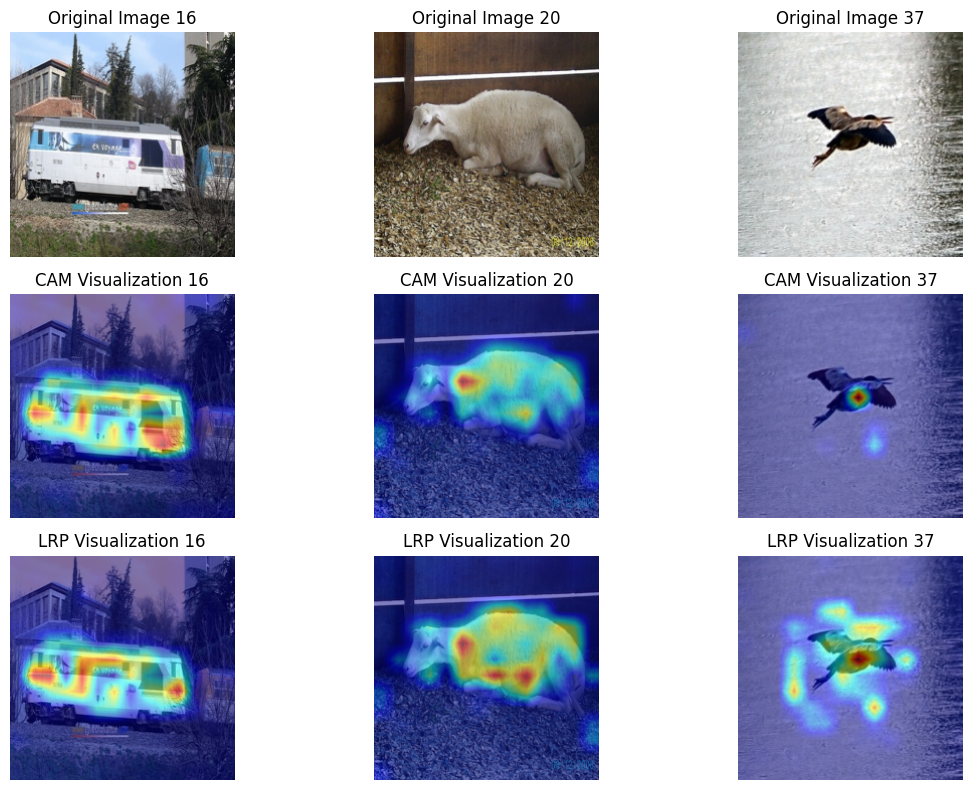

In [31]:
import torchvision.transforms as transforms
# Create a plot with 2 rows and 3 columns for the images (original and CAM visualizations)
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
use_thresholding = False

# Loop through the selected dataset indices
# 1,8
for idx, i in enumerate([16,20,37]):
    # Load the image and its mask
    image, true_mask = dataset[i]
    image_resized, true_mask_np_resized = manipulate_img(image, true_mask)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model1(image_resized.unsqueeze(0).cuda())

    # Generate CAM visualization
    vis, vis_mask = visualize_CAM(image_resized, use_thresholding=False)
    vis1, vis_mask1 = visualize_LRP(image_resized)

    # Plot original image
    axes[0, idx].imshow(image_np_resized)
    axes[0, idx].set_title(f"Original Image {i}")
    axes[0, idx].axis('off')  # Hide axes

    # Plot the CAM visualization
    axes[1, idx].imshow(vis)
    axes[1, idx].set_title(f"CAM Visualization {i}")
    axes[1, idx].axis('off')  # Hide axes

    axes[2, idx].imshow(vis1)
    axes[2, idx].set_title(f"LRP Visualization {i}")
    axes[2, idx].axis('off')  # Hide axes

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.savefig('cam_visualizations.png', dpi=300)
plt.show()

Metrics

In [32]:
import torchvision.transforms as transforms

def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()

# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    image_resized, true_mask_np_resized = manipulate_img(image, true_mask)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 70%
    if top_prob > 0.85:
          for method in ["CAM", "LRP"]:
            # Generate visualization
            if method == "CAM":
              vis, vis_mask = visualize_CAM(image_resized, use_thresholding=False)
            else:  # For LRP
              vis, vis_mask = visualize_LRP(image_resized, class_index=None)


            # Compute metrics
            predicted_mask_np = (vis_mask > 0.5).astype(np.uint8)
            true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

            # Flatten the masks for metric calculation
            true_mask_flat = true_mask_resized.flatten()
            predicted_mask_flat = predicted_mask_np.flatten()

            jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
            f1 = f1_score(true_mask_flat, predicted_mask_flat)
            pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

            # Store metrics
            all_results.append({
                "Image Index": idx,
                "Method": method,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv("segmentation_metrics.csv", index=False)

print("Metrics have been saved to segmentation_metrics.csv")


Processing:   4%|▍         | 64/1449 [00:07<02:26,  9.43image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing:  40%|████      | 586/1449 [01:01<01:02, 13.71image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing:  85%|████████▌ | 1237/1449 [02:12<00:20, 10.43image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing:  92%|█████████▏| 1329/1449 [02:21<00:14,  8.43image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing: 100%|██████████| 1449/1449 [02:33<00:00,  9.42image/s]

Metrics have been saved to segmentation_metrics.csv


In [33]:
# Load the CSV file
results_df = pd.read_csv("segmentation_metrics.csv")

# Calculate the average metrics per method
average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics_85.csv", index=False)

# Print the average metrics
print(average_metrics)

  Method  Image Index  Jaccard Index (IoU)  F1 Score  Pixel Accuracy
0    CAM   722.642651             0.043563  0.074916        0.664964
1    LRP   722.642651             0.142886  0.229618        0.703548


In [34]:
import numpy as np
import torch
import cv2
from sklearn.metrics import auc  # For Area Under Curve

def deletion_metric(model, image, attribution_map, class_index=None, steps=100):
    """
    Computes the Deletion Metric for a given attribution map.

    Parameters:
    - model: Trained model used for classification.
    - image: Input image tensor (C, H, W).
    - attribution_map: The heatmap from CAM or LRP, normalized [0, 1].
    - class_index: Class index to track model confidence for (optional).
    - steps: Number of steps for iterative deletion.

    Returns:
    - auc_score: Area under the confidence curve (lower = better attribution).
    - confidence_drop: List of model confidences after each deletion step.
    """
    model.eval()

    # Flatten the attribution map and sort pixel indices by importance (descending order)
    importance_order = np.argsort(-attribution_map.flatten())

    # Create a copy of the image for deletion process
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
    modified_image = image_np.copy()

    # Initial model confidence before deletion
    with torch.no_grad():
        output = model(image.unsqueeze(0).cuda())
        if class_index is None:
            class_index = output.argmax().item()
        initial_confidence = torch.softmax(output, dim=1)[0, class_index].item()

    confidence_drop = [initial_confidence]

    # Deletion process: remove pixels in steps
    total_pixels = image_np.shape[0] * image_np.shape[1]
    pixels_per_step = total_pixels // steps

    for step in range(1, steps + 1):
        # Mask out the most important pixels
        pixels_to_mask = importance_order[(step - 1) * pixels_per_step: step * pixels_per_step]

        # Set those pixels to zero (blackout)
        for idx in pixels_to_mask:
            h, w = divmod(idx, image_np.shape[1])  # Convert 1D index to 2D coordinates
            modified_image[h, w, :] = 0  # Black out across all channels

        # Convert modified image back to tensor
        modified_image_tensor = torch.from_numpy(modified_image).permute(2, 0, 1).float().cuda()

        # Recalculate model confidence
        with torch.no_grad():
            output = model(modified_image_tensor.unsqueeze(0))
            confidence = torch.softmax(output, dim=1)[0, class_index].item()

        confidence_drop.append(confidence)

    # Calculate Area Under the Confidence Curve (AUC)
    x_axis = np.linspace(0, 1, len(confidence_drop))  # Percentage of pixels deleted
    auc_score = auc(x_axis, confidence_drop)

    return auc_score, confidence_drop


In [43]:
auc_cam_list = []
auc_lrp_list = []
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    image_resized, true_mask_np_resized = manipulate_img(image, true_mask)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)
    if top_prob > 0.85:
        # Generate CAM and LRP visualizations
        cam_vis, cam_mask = visualize_CAM(image_resized)
        lrp_vis, lrp_mask = visualize_LRP(image_resized)

        # Deletion Metric for CAM
        auc_cam, cam_conf_drop = deletion_metric(model1, image_resized, cam_mask)

        # Deletion Metric for LRP
        auc_lrp, lrp_conf_drop = deletion_metric(model1, image_resized, lrp_mask)
        auc_cam_list.append(auc_cam)
        auc_lrp_list.append(auc_lrp)

print(f"CAM Deletion AUC: {sum(auc_cam_list)/len(auc_cam_list)}")
print(f"LRP Deletion AUC: {sum(auc_lrp_list)/len(auc_lrp_list)}")

Processing:   4%|▍         | 62/1449 [00:54<19:42,  1.17image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing:  40%|████      | 586/1449 [08:12<07:38,  1.88image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing:  85%|████████▌ | 1237/1449 [17:57<02:43,  1.29image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing:  92%|█████████▏| 1329/1449 [19:09<02:10,  1.09s/image]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing: 100%|██████████| 1449/1449 [20:46<00:00,  1.16image/s]

CAM Deletion AUC: 0.24672662325612663
LRP Deletion AUC: 0.12430721068001194


In [44]:
import numpy as np
import torch
import cv2

# Pointing Game Evaluation Function
def pointing_game(attribution_map, ground_truth_mask):
    # Step 1: Find the most important pixel in the attribution map
    max_point = np.unravel_index(np.argmax(attribution_map), attribution_map.shape)

    # Step 2: Check if this point falls within the ground truth mask (1 = foreground, 0 = background)
    if ground_truth_mask[max_point] == 1:
        return 1  # Hit
    else:
        return 0  # Miss

# Loop for evaluating over the dataset
def evaluate_pointing_game(dataset, method='CAM'):
    hits = 0
    total_samples = len(dataset)

    for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
        image, true_mask = dataset[idx]
        image_resized, true_mask_resized = manipulate_img(image, true_mask)

        # Generate attribution map
        if method == 'CAM':
            _, attribution_map = visualize_CAM(image_resized, use_thresholding=False)
        elif method == 'LRP':
            _, attribution_map = visualize_LRP(image_resized, class_index=None)
        else:
            raise ValueError("Unsupported method")

        # Resize ground truth mask to match attribution map (224x224)
        true_mask_resized = cv2.resize(true_mask_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

        # Apply Pointing Game
        hit = pointing_game(attribution_map, true_mask_resized)
        hits += hit

    # Compute Pointing Game Accuracy
    accuracy = hits / total_samples
    return accuracy

# Example Usage
cam_accuracy = evaluate_pointing_game(dataset, method='CAM')
lrp_accuracy = evaluate_pointing_game(dataset, method='LRP')

print(f"CAM Pointing Game Accuracy: {cam_accuracy:.4f}")
print(f"LRP Pointing Game Accuracy: {lrp_accuracy:.4f}")


Processing:   4%|▍         | 64/1449 [00:03<01:06, 20.90image/s]<ipython-input-5-0d69abe825a4>:3: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
Processing: 100%|██████████| 1449/1449 [06:09<00:00,  3.92image/s]

CAM Pointing Game Accuracy: 0.4424
LRP Pointing Game Accuracy: 0.7198
